In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Define the file path of the sensor data CSV file
file_path = '/content/drive/MyDrive/MC/MC_A3_1/sensor_data.csv'

data_frame = pd.read_csv(file_path)
data_frame

,Timestamp,X,Y,Z
0,0,0.70005,5.401950,7.339951
1,1,0.41505,5.622000,7.945951
2,2,-4.51605,3.180000,13.411951
3,3,5.87895,6.336000,-0.901950
4,4,1.17600,3.496050,-9.100050
...,...,...,...,...
170,170,-5.23005,-2.977050,18.433050
171,171,-2.87205,5.991000,2.959050
172,172,-4.35600,7.504050,4.711050
173,173,1.30095,9.136950,8.266951


1/1 [==============================] - 0s 464ms/step


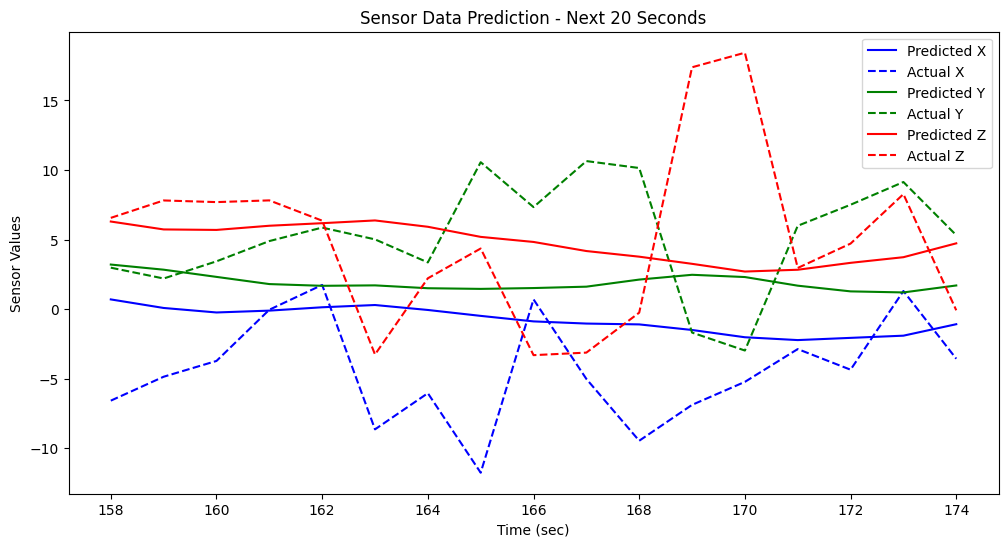

In [34]:
# Extract sensor data (X, Y, Z) from the DataFrame
sensor_data = data_frame[['X', 'Y', 'Z']]

# Extract time intervals (index values) from the DataFrame
time_intervals = data_frame.index.values

# Scale the sensor data using MinMaxScaler to normalize values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
data_values = sensor_data.values
scaled_data = scaler.fit_transform(data_values)

# Define a function to create sequences of input-output pairs for LSTM training
def create_sequences(data, sequence_length):
    X_sequence, y_sequence = [], []
    for i in range(len(data) - sequence_length):
        X_sequence.append(data[i:i + sequence_length, :])
        y_sequence.append(data[i + sequence_length, :])
    return np.array(X_sequence), np.array(y_sequence)

# Define the length of sequences (number of time steps to consider)
sequence_length = 10

# Create sequences of input-output pairs for training the LSTM model
X_sequence, y_sequence = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
train_size = int(len(X_sequence) * 0.9)
X_train, X_test = X_sequence[:train_size], X_sequence[train_size:]
y_train, y_test = y_sequence[:train_size], y_sequence[train_size:]

# Define the LSTM model architecture using Keras Sequential API
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(3))  # Output layer with 3 units (for X, Y, Z)
model.compile(loss='mean_squared_error', optimizer='adam')  # Compile the model

# Train the LSTM model on the training data
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Make predictions on the testing data using the trained model
predicted_values = model.predict(X_test)

# Inverse transform the predicted values and actual values to original scale
predicted_values = scaler.inverse_transform(predicted_values)
y_test = scaler.inverse_transform(y_test)

# Plot the predicted and actual sensor values over time
plt.figure(figsize=(12, 6))
colors = ['blue', 'green', 'red']

for i in range(3):
    plt.plot(time_intervals[sequence_length + train_size:], predicted_values[:, i], label=f'Predicted {["X", "Y", "Z"][i]}', color=colors[i])
    plt.plot(time_intervals[sequence_length + train_size:], y_test[:, i], label=f'Actual {["X", "Y", "Z"][i]}', linestyle='--', color=colors[i])

plt.title('Sensor Data Prediction - Next 20 Seconds')  # Set plot title
plt.xlabel('Time (sec)')  # Set x-axis label
plt.ylabel('Sensor Values')  # Set y-axis label
plt.legend()  # Display legend
plt.show()  # Show the plot
